강화학습 DQN

- 주어진 환경과 상호작용하여 좋은 점수를 얻는 방향으로 성장하는 머신러닝 분야를 강화학습이라고 한다. 
- 강화학습은 사람이 목표를 설정해주고 시행착오를 겪으며 좋은 피드백 받는 쪽으로 최적화 하며 성장한다. 
- 강화학습은 크게 상태, 에이전트, 행동, 보상 4가지 요소로 나눌 수 있다. 
    - 에이전트 : 인공지능 플레이어
    - 환경 : 에이전트가 솔루션을 찾기 위한 무대 
    - 행동 : 에이전트가 환경 안에서 시행하는 상호작용
    - 보상 : 에이전트의 행동에 따른 점수 or 결과 
    
- 강화학습은 고전적인 Q-Learning 강화학습 알고리즘에 신경망과 여러 기법을 접목한 결과이다. 
- DQN의 주요 특징은 기억하기와 다시 보기이다. 

In [3]:
#카트폴 게임을 통한 DQN실습

#필요 라이브러리 임포트
import gym #카트폴 게임환경
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque # 선입선출 자료구조의 일종인 큐 자료구조의 일종으로, 덱은 일반적인 큐와 다르게 양쪽 끝에서 삽입, 삭제가 모두 가능한 자료구조 
import matplotlib.pyplot as plt



In [8]:
#하이퍼 파라미터 정의 

EPISODES = 50 #에피소드 반복수
EPS_START = 0.9 #학습 시작 시 에이전트가 무작위 행동 확률 / 10%는 학습된 방향으로 행동
EPS_END = 0.05 #학습 막바지 에이전트가 무작위로 행동 확률 / 95%는 학습된 방향으로 행동
EPS_DECAY = 200 #학습 진행 시, 에이전트 무작위 행동 확률 감소시키는 값 ( EPS_START -> EPS_END 까지 점진적으로 감소시키는 값)
GAMMA = 0.8 #할인계수 ( 현재 보상을 미래 보상보다 얼마나 가치 있게 여기는 지 )
LR = 0.001 #학습률
BATCH_SIZE = 64 

In [9]:
#DQN 에이전트 클래스 생성
# 신경망 / 행동 결정 위한 함수, 각 행동 가지 학습 함수 포함 

#신경망에는 카트위치, 카트 속도, 막대기 각도, 막대기 속도 4가지 정보를 입력받아 왼쪽으로 갈때, 오른쪽으로 갈 떄의 가치를 출력
#처음 시작 노드는 4개, 마지막 출력 노드는 왼쪽, 오른쪽으로 갈때 가치를 정하는 2개의 노드로 구성 

class DQNAgent :
    def __init__(self):
        self.model = nn.Sequential(nn.Linear(4,256),
                                  nn.ReLU(),
                                  nn.Linear(256,2))
        
        #최적화 함수 Adam이용
        self.optimizer = optim.Adam(self.model.parameters(),LR)
        self.steps_done = 0
        #이전의 경험들을 배열에 담아 계속 재학습 시키며 신경망이 잊지 않게 한다는 아이디어
        #기억한 경험들은 학습시 무작위로 뽑아 경험 간의 상관관계를 줄인다. 
        #경험을담는 memory 생성
        self.memory = deque(maxlen=10000) #maxlen으로 큐가 가득찬 경우 제일 오래된 요소부터 없앤다.
    
    #memorize에서는 self.memory 배열에 현재 상태, 현재 행동, 행동에 대한 보상, 행동으로 인한 새로운 상태를 저장 
    def memorize(self, state, action, reward, nex_state):
        self.memory.append((state,
                           action, 
                           torch.FloatTensor([reward]),
                           torch.FloatTensor([next_state])))
    
    #무작위로 숫자를 골라 앱실론 값보다 높으면 신경망이 학습하어 행동하게 한다. (낮으면 무작위 행동)
    #초반에는 앱실론 값을 높게 주어 다양한 경험을 시도하고,점점 그 값을 낮춰가며 신경망 결정의 비율을 높인다. 
    #이 알고리즘을 엡실론 그라디 알고리즘이라고 한다. (엡실론 탐욕)
    def act(self, state):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * self.steps_done/EPS_DECAY)
        self.steps_done += 1
        if random.random() > eps_threshold:
            return self.model(state).data.max(1)[1].view(1,1)
        else:
            return torch.LongTensor([[random.randrange(2)]])
    
    #경험 리플레이를 진행하며, slef.model을 self.memory에 쌓인 경험을 토대로 학습시키낟. 
    #배치사이즈 보다 커질 때 까지, return으로 학습을 거르고 경험이 충분히 쌓이면
    #self.memory 쿠에서 무작위로 배치 크기만큼의 경험들을 무작위로 가져온다. (상관성 감소)
    def learn(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states = zip(*batch) #한 세트의 배열을 4개의 배열로 분할
        
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)
        
        #행동의 가치(Q)를 더 잘 예측하도록 행동의 가치를 추출
        #현재 상태(states)를 신경망에 통과시켜 왼쪽으로 가는 행동과 오른쪽으로 가는 행동에 대한 가치 계산
        #gather()함수로 에이전트가 현재 행동의 가치를 current_q에 저장 
        current_q = self.model(states).gather(1, actions)
        #할인된 미래가치(미래의 행동의 최대 가치)로 누적된 보상을 극대화 하는 방향으로 이루어진다. 
        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (GAMMA * max_next_q) #현재 상태의 보상에 에이전트가 내다보는 미래가치가 더해져 할인된 미래가치를 담는다. 
        
        loss = F.mse_loss(current_q.squeeze(), expected_q)#손실함수로 오차 계산 (mse)
        self.optimizer.zero_grad()#기울기 초기화
        loss.backward()#역전파 
        self.optimizer.step()#신경망학습

In [10]:
#학습 준비
agent = DQNAgent() #인스턴스화 
env = gym.make('CartPole-v0')#카트폴 환경의 게임 환경 생성(에이전트의 행동 입력 및 다음 상태와 게임종료 여부 출력)
score_history = []

에피소드 :1  // 점수 : 19
에피소드 :2  // 점수 : 11
에피소드 :3  // 점수 : 13
에피소드 :4  // 점수 : 67
에피소드 :5  // 점수 : 24
에피소드 :6  // 점수 : 12
에피소드 :7  // 점수 : 16
에피소드 :8  // 점수 : 11
에피소드 :9  // 점수 : 9
에피소드 :10  // 점수 : 11
에피소드 :11  // 점수 : 12
에피소드 :12  // 점수 : 15
에피소드 :13  // 점수 : 11
에피소드 :14  // 점수 : 13
에피소드 :15  // 점수 : 9
에피소드 :16  // 점수 : 12
에피소드 :17  // 점수 : 31
에피소드 :18  // 점수 : 54
에피소드 :19  // 점수 : 113
에피소드 :20  // 점수 : 121
에피소드 :21  // 점수 : 67
에피소드 :22  // 점수 : 93
에피소드 :23  // 점수 : 81
에피소드 :24  // 점수 : 157
에피소드 :25  // 점수 : 100
에피소드 :26  // 점수 : 136
에피소드 :27  // 점수 : 136
에피소드 :28  // 점수 : 111
에피소드 :29  // 점수 : 129
에피소드 :30  // 점수 : 158
에피소드 :31  // 점수 : 122
에피소드 :32  // 점수 : 101
에피소드 :33  // 점수 : 140
에피소드 :34  // 점수 : 183
에피소드 :35  // 점수 : 110
에피소드 :36  // 점수 : 134
에피소드 :37  // 점수 : 153
에피소드 :38  // 점수 : 152
에피소드 :39  // 점수 : 152
에피소드 :40  // 점수 : 179
에피소드 :41  // 점수 : 167
에피소드 :42  // 점수 : 135
에피소드 :43  // 점수 : 200
에피소드 :44  // 점수 : 162
에피소드 :45  // 점수 : 145
에피소드 :46  // 점수 : 141
에피소드 :47  // 점수 : 12

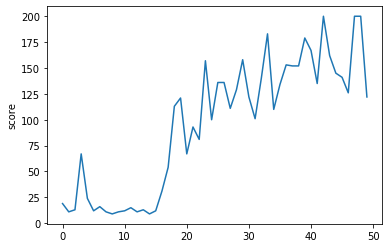

In [11]:
#학습 시작
for e in range(1, EPISODES +1):
    state = env.reset()
    steps = 0
    #게임이 끝날 때 까지 행동을 멈추지 않으므로 무한 반복문을 만들고 env.render()로 게임화면을 띄운다. 
    while True:
        env.render()
        state = torch.FloatTensor([state])
        action = agent.act(state) #매 턴마다 입력으로 사용 
        next_state, reward, done, _ = env.step(action.item()) #action은 텐서로, 에이전트가 한 행동의 번호를 추출하여 step함수에 입력하여 다음 행동의 상태, 보상, 종료여부 출력
        
        #done으로 게임이 끝났는지를 True, False로 표현 
        #게임이 끝나면 마이너스 보상 추가
        if done :
            reward = -1 #막대가 넘어져 게임이 끝난 경우 
            
        agent.memorize(state, action, reward, next_state)
        agent.learn()
        
        state = next_state
        steps +=1
        
        #게임이 끝나고 숫자와 점수 표기 및, score_history 리스트에 점수 append를 시킨 후 무한 반복 문 탈출 
        if done :
            print('에피소드 :{}  // 점수 : {}'.format(e, steps))
            score_history.append(steps)
            break
            
plt.plot(score_history)
plt.ylabel('score')
plt.show()